In [ ]:
# Imports

import os
import time
import json
import re

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics, model_selection

# Jazz chord recognition

### Project in course DT2470 Music Informatics

Simon Falk, simonfal@kth.se

Make sure the folder project_data_simonfal is in the same directory as this notebook, please.

## Summary

In this project I investigated if it's possible to retrieve chord symbols from chroma features by learning from large amounts of annotated data. The dataset used consists of chroma features and chord annotations for 112 jazz songs. I have not chosen this dataset because it's suitable for chord recognition, rather on the contrary, jazz chords are intrinsically hard to classify (even for the human ear).

## Feature and label extraction

Audio was sampled at 44.1 kHz and then processed by the short-time Fourier transform with a hop size of 2048 frames to give a chromagram with 21.53 chroma vectors per second. (Not done by me, but according to documentation it was done this way.) I will call the set of chroma vectors $X = [x_i^{(1)} x_i^{(2)} \dots x_i^{(12)}]_{i=1 \dots N}$, and $N$ is the total number of chroma vectors for all songs.

The chroma vectors were then logarithmically compressed using $\gamma=10$.

I grouped the different chords into 5 classes:
* major
* minor
* dominant-seventh
* half-diminished
* diminished

These classes have support from jazz music theory and were proposed by the authors (Eremenko et. al, 2018) of the dataset. Now, there were a lot of chords in the annotations that had abbreviations like `F#:(3, #5, b7, 11)` or something alike. (The numbers denote inside the parentheses denote intervals from the root of the chord.) Since I both felt I would spend too time writing a string processing algorithm and also that I was unsure how to classify these more exotic chords into the five base classes, I would discard those chords.

Each chord maps to a number from 1 to 60 corresponding to the 12 different keys and the five different chord groups. Aligning everything to the feature rate of the chromas, we get a label vector $y$ of the same length as the feature vector $X$.

In [ ]:
pre_path = ''
dataset_path = 'project_data_simonfal/JAAH-master/'
features_path = pre_path + dataset_path + 'features/'
annotations_path = pre_path + dataset_path + 'annotations/'


In [ ]:
db_file = open(features_path + 'db.json', 'r')
songs = json.load(db_file)
db_file.close()

In [ ]:
def flatten_and_align(parts_list):
    '''
    Nested list is flattened into a single list and 
    chord chart syntax is interpreted.
    
    Input: List of different parts of the song,
    each consisting of a dictionary {beats: [], chords: []}
    holding two lists mapping each chord to a time code of the song.
    Output: (t, C)
    where t :    1d numpy array of time codes
    and   C :    1d numpy array of chord symbols (string)
    '''
    t = []
    C = []
    
    for i, part in enumerate(parts_list):
        if len(t) > 0:
            assert part["beats"][0] > t[-1]
        times = part["beats"]
        
        chord_str = "".join(part["chords"])
        measures = re.split('\|{1,2}',chord_str)[1:-1]
        chords = []
        for m in measures:
            chord_set = re.split(' ', m)[:-1]
            if len(chord_set) == 1:
                chord_set = 4 * chord_set
            elif len(chord_set) == 2:
                chord_set = 2 * [chord_set[0]] + 2 * [chord_set[1]]
            chords.extend(chord_set)
            
        if len(times) != len(chords):
            t.extend(times)
            C.extend(["N"]*len(times))
        else:
            t.extend(times)
            C.extend(chords)
    
    t = np.array(t)
    C = np.array(C)
    return t, C


def frame_chords(n_of_frames, feature_rate, time_vector, chord_vector):
    '''
    List of chords and time codes are aligned to the time codes related to
    the rate with which features are given.
    
    Input: (n_of_frames, feature_rate, time_vector, chord_vector)
    where n_of_frames  :    length of feature sequence,
          feature_rate :    # features per seconds,
          time_vector  :    list of time codes,
          chord_vector :    list of chord symbols. 
    The two lastmentionened have the same length.
    
    Output: list of chords symbols having same length as feature sequence.
    
    '''
    C_t = []
    pointer = 0
    
    for n in range(n_of_frames):
        t = n*1.0/feature_rate
        t_mid = (n+0.5)/feature_rate
        
        if np.abs(time_vector[pointer] - t_mid) <= 0.5/feature_rate:
            C_t.append(chord_vector[pointer])
            pointer += 1
        else:
            if pointer == 0:
                C_t.append('N')
            else:
                C_t.append(chord_vector[pointer-1])
    return C_t


def number_chords(chord_vector):
    '''
    Translate a sequence of chord symbols into sequence of integers
    where we have defined a map between chords and numbers
    
    Input: list of chords
    Output: list of indices
    '''
    note_names = ['C','C#','D','Eb','E','F','F#','G','G#','A','Bb','B']
    note_dict = {
        'C' : 0,
        'C#' : 1,
        'Db' : 1,
        'D' : 2,
        'D#' : 3,
        'Eb' : 3,
        'E' : 4,
        'F' : 5,
        'F#' : 6,
        'Gb' : 6,
        'G' : 7,
        'G#' : 8,
        'Ab' : 8,
        'A' : 9,
        'A#' : 10,
        'Bb' : 10,
        'B' : 11
    }
    qual_dict = {
        'maj7' : 0,
        'maj7/3' : 0,
        'maj6' : 0,
        'maj9' : 0,
        'min' : 1,
        'min7' : 1,
        'min6' : 1,
        'minmaj7' : 1,
        'min9' : 1,
        '7' : 2,
        '9' : 2,
        '7/5' : 2,
        'aug' : 2,
        'hdim7' : 3,
        'dim7': 4,
        'dim' : 4
    }
    indices = []
    count_labeled = 0
    for chord_str in chord_vector:
        if re.match('N', chord_str):
            indices.append(0)
            count_labeled += 1
        else:
            splitted = chord_str.split(":")
            if len(splitted) == 1:
                quality = 0
            else:
                if splitted[1][0] == '(':
                    indices.append(0)
                    continue
                else:
                    quality = qual_dict[splitted[1].split("/")[0]]
            count_labeled += 1
            try:
                note = note_dict[splitted[0]] + 1
                indices.append(note + quality*12)
            except KeyError:
                indices.append(0)
            
    labeled_ratio = count_labeled/len(chord_vector)
    return indices, labeled_ratio


def compress_log(values, gamma=1):
    '''values is a np array, 
    gamma is the compression constant'''
    return np.log(np.ones(values.shape) + gamma*values)

In [ ]:
def retrieve_data(gamma=10):
    X_src = np.zeros((0,12))
    y_src = np.zeros((0))
    starting_points = []
    idx = 0
    for song_obj in songs[:32] + songs[33:64] + songs[65:]:
        song_name = song_obj['nnls_chroma']['path'].split('.')[0]
        step_size = int(song_obj['nnls_chroma']['step_size'])
        sample_rate = int(song_obj['nnls_chroma']['sample_rate'])
        feature_rate = sample_rate * 1.0 / step_size
        
        if os.path.isfile(features_path + song_name + '.csv'):
            chroma_file = open(features_path + song_name + '.csv')
            chroma_raw = chroma_file.readlines()
            chroma_file.close()
        
        song_chroma = []
        for i in range(len(chroma_raw)):
            song_chroma.append([
                                float(ele) for ele in 
                                chroma_raw[i].strip().split(',')[1:]
            ])
        
        song_chroma = compress_log(np.array(song_chroma), gamma=gamma)
        
        # Collect annotations
        if os.path.isfile(annotations_path + song_name + '.json'):
            json_file = open(annotations_path + song_name + '.json')
            noted_obj = json.load(json_file)
            json_file.close()
        
        t, C = flatten_and_align(noted_obj.pop("parts"))
        if len(t) > 2:
            frames_retrieved = len(t)
            t_of_last_retrieval = t[-1]
            frames_used = min(len(song_chroma), int(t[-1]*feature_rate-1))
            F = frame_chords(frames_used, feature_rate, t, C)
            chord_indices, ratio = number_chords(F)
            y_src = np.concatenate((y_src, np.array(chord_indices)))
        else:
            frames_retrieved = 0
            frames_used = 0
        
        X_src = np.concatenate((X_src, song_chroma[:frames_used]))
        idx += 1
        
    return X_src, y_src

In [ ]:
def nan_process(X,y):
    # Throw away data labeled as NAN
    nan_idx = np.where(y==0)[0]
    y_clean = np.delete(y, nan_idx)
    X_clean = np.delete(X, nan_idx, axis=0)
    y_0 = np.subtract(y_clean, [1]).astype(int)
    # y now goes from 0 to 59 instead of 1 to 60
    return (X_clean, y_0)


## Method 1 - using class mean similarity

This method is taken from chapter 5.2 in Müller's textbook and makes use of templates, which are supposed to hold the correct representation of a particular chord. The templates used here will be inferred by taking the mean of all chromas belonging to a certain class (having a certain value of $y$ in the range 1 to 60).

We try to mitigate the problem that there are a lot of F chords and only a few F# chords to learn from, by shifting all chords down to C by cyclic permutation, before taking the mean. This is common practice in chord recognition literature. We thus get one mean for major chords, one for minor chords and so on. Before moving on we also have to permute each of the mean vectors back to all 12 keys, resulting in 60 template vectors ${t_1, t_2, \dots t_{60}}$. We have also normalized each template vector so that the sum over all 12 components is 1. For future reasons define the 60x12 matrix $\mathbf{T}$ through $T^T=[t_1 | t_2 | \dots | t_{60}]$

Müller proposes that we for classification compute the cosine similarity $$s(x,y) = \frac{x\cdot y}{\|x\| \cdot \|y\|}$$ between each 12-dimensional test vector $v$ and each of the templates vectors, and then assigns $v$ to the class $\hat{y}$ for which this similarity value is largest. To simplify computations we rewrite this in matrix notation as $$\hat{y} = \arg \max_i [\mathbf{T} v^T]_i$$

In [ ]:
def sim_train(X_train,y_train):

    def decode_i(i):
        return (i//12, i%12)

    def encode_i(q, n):
        return q*12 + n

    # Produce y vector per quality
    # and modify X matrix so all chords are in C

    y_qual = np.zeros_like(y_train)
    X_shifted = np.zeros_like(X_train)

    for i in range(60):
        q, n = decode_i(i)
        # Index set of members of specific class
        idx = np.where(y_train == i)[0]
        if len(idx) == 0: # if there is no data for that chord
            continue
        X_idx = np.take(X_train, idx, axis=0)
        y_qual[idx] = q
        X_shifted[idx] = np.roll(X_idx, -n)

    # compute mean and standard deviation
    means_flat = np.zeros((60,12))
    stds_flat = np.zeros((60,12))
    covs = np.zeros((60,12,12))

    for q in range(0,5): # disregard NAN class
        idx = np.where(y_qual == q)[0]
        X_idx = np.take(X_shifted, idx, axis=0)
        means_flat[encode_i(q, 0)] = np.mean(X_idx, axis=0)
        stds_flat[encode_i(q, 0)] = np.std(X_idx, axis=0, ddof=1)
        covs[encode_i(q, 0)] = np.cov(X_idx, rowvar=False)
        '''
        # Uncomment to see how the mean vectors look like
        quals = ["Maj","Min","Dom7","Minb5","Dim"]
        plt.title(quals[q])
        plt.pcolormesh([np.mean(X_idx, axis=0)])
        plt.colorbar()
        
        plt.xticks(np.arange(12), ['C','C#','D','Eb','E','F','F#','G','Ab','A','Bb','B'])
        plt.show()
        '''

        for n in range(1, 12):
            # roll means and std over all notes
            i_current = encode_i(q, n)
            i_base = encode_i(q, 0)
            means_flat[i_current] = np.roll(means_flat[i_base], n)
            stds_flat[i_current] = np.roll(stds_flat[i_base], n)
            covs[i_current] = np.cov(np.roll(X_idx, n, axis=1), rowvar=False)

    return means_flat, stds_flat, covs


In [ ]:
def sim_test(X_test, T):
    T_norm = np.reciprocal(np.linalg.norm(T, axis=1))
    T_norm[0] = 0
    labels = []
    for n in range(len(y_test)):
        labels.append(np.argmax(np.multiply(T_norm,T@X_test[n].T)))
    return labels

## Results

We divided the availiable data into a training and a test set (80/20) and obtained the labels $\hat{y}$ as explained in the section above. This was repeated 10 times in which the splits was repeated. This simple classification algorithm was not impressively good at classifying the chords correctly. About 18% of the chords were correctly classified, as shown below.

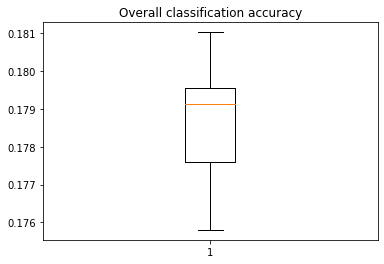

In [ ]:
scores = np.zeros((10))
for n in range(10):
    X_src, y_src = retrieve_data()
    X, y = nan_process(X_src, y_src)
    X_train, X_test, y_train, y_test = model_selection.train_test_split(
        X, y , test_size=0.2)
    T, _, _ = sim_train(X_train, y_train)
    labels = sim_test(X_test, T)
    scores[n] = metrics.accuracy_score(y_test, labels)
plt.title("Overall classification accuracy")
plt.boxplot(scores)
plt.show()

The chord classes are made up of two "properties" - key, and quality. A question is whether the algorithm was able to recognize any of the two properties better than the other. One could argue that key should be more distinguishable, since 1) it is more tightly linked to the information from the chromagram and 2) the division of chord classes into qualities was somwhat arbitrarily done and the mutual similarity between template chords is high.

The confusion matrix below is defined so that element (i,j) tells the relative frequency of assigning class j to a vector that was in fact of class i, normalized w.r.t. the number the class was predicted. Given that we predict X to be a certain class k, this table now tells us the probability of the class actually being k. The matrix is visualized as a diagram with bright colors indicating high values. Here we might be tempted to say that our suspicion was right. When we make a prediction for a certain chord quality, often it turns out that some of the other classes was in fact correct, whereas when we predict for a certain key the true keys are better aligned with the predicted ones.


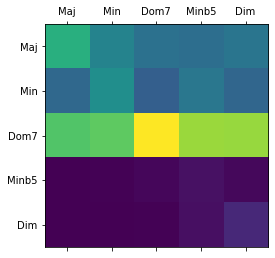

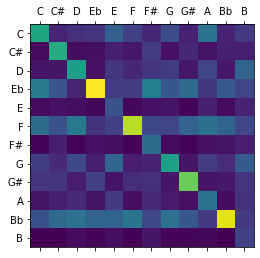

In [ ]:
X_src, y_src = retrieve_data()
X, y = nan_process(X_src, y_src)
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y , test_size=0.2)
T, _, _ = sim_train(X_train, y_train)
labels = sim_test(X_test, T)
scores[n] = metrics.accuracy_score(y_test, labels)

y_test_quals = [y//12 for y in y_test]
labels_quals = [y//12 for y in labels]

y_test_keys = [y%12 for y in y_test]
labels_keys = [y%12 for y in labels]

plt.matshow(metrics.confusion_matrix(y_test_quals,labels_quals, normalize='pred'))
plt.xticks(np.arange(5),["Maj","Min","Dom7","Minb5","Dim"])
plt.yticks(np.arange(5),["Maj","Min","Dom7","Minb5","Dim"])
plt.show()
plt.matshow(metrics.confusion_matrix(y_test_keys,labels_keys, normalize='pred'))
plt.xticks(np.arange(12),['C','C#','D','Eb','E','F','F#','G','G#','A','Bb','B'])
plt.yticks(np.arange(12),['C','C#','D','Eb','E','F','F#','G','G#','A','Bb','B'])
plt.show()

However, the big issue here is that the dataset is skewed, i.e. the class sizes are highly uneven. Therefore the dark parts of the matrix might just be a cause of that class having very few samples in the dataset. This is a point where some improvement for the chord recognition algorithm could be made, and we will discuss this more later. As a final experiment on method 1, we will investigate the effect of changing the compression parameter $\gamma$, which controls how much the peak value of the chromagram should stand out compare to the other values. We try 3 different parameters for $\gamma$ and note that accuracy seems to go down with increasing values. This suggests that the algorithm work better with more contrast between components.

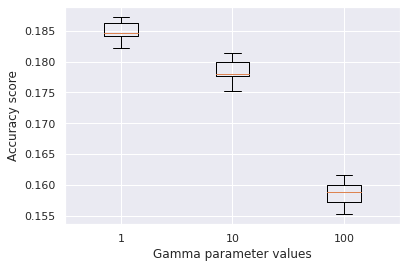

In [ ]:
# Testing different values of compression parameter gamma
scores = np.zeros((3,10))
for g, gamma in enumerate([1,10,100]):
    for n in range(10):
        X_src, y_src = retrieve_data(gamma=gamma)
        X, y = nan_process(X_src, y_src)
        X_train, X_test, y_train, y_test = train_test_split(
            X, y , test_size=0.2)
        T, _, _ = sim_train(X_train, y_train)
        labels = sim_test(X_test, T)
        scores[g][n] = metrics.accuracy_score(y_test, labels)

plt.boxplot(scores.T)
plt.xlabel("Gamma parameter values")
plt.xticks([1,2,3],[1,10,100])
plt.ylabel("Accuracy score")
plt.show()

## Method 2 - with a HMM model

A Hidden Markov Model (HMM) is proposed in Müller's textbook as another solution to the chord recognition problem. In chaper 5.3 he suggests modelling the chord classes as hidden states and chroma expressions as observations. This HMM reflects both the dependence of the previous chord for estimating the next, and that the true state of a particular chord is hidden and is only seen through chromagrams. If we could shuffle our data for the train/test split in Method 1, this would be unappropriate for Method 2. Now we want our data to reflect the relative alignment in time of the chroma vectors.

There are different methods for learning the HMM parameters $\mathbf{A}$, $\mathbf{B}$ and $\mathbf{\pi}$. Firstly, regarding $\mathbf{A}$ (the matrix of transmission probabilities), one simple method is to count bigrams - i.e. the number of times one chord comes after another in the annotations. Secondly, the observation space is modelled as a multivariate gaussian distribution, making use of the class means we calculated for Method 1. The covariance matrix can't be limited to a diagonal matrix: assuming independence among regressors would be unjustified, just because a note being played would influence the chroma components of all its harmonics. In this approach, we don't train our Gaussian parameters in the Baum-Welch algorithm, since we assume that they already reflect the totality of our training data as they were computed from Method 1.

One could choose to train the transmission probabilities $\mathbf{A}$ inside the Baum-Welch. But this is essentially a very similar procedure as bigram counting, since Baum-Welch reestimates $\mathbf{A}$ based on how many transmissions was made from one state to another. Simulations showed similar accuracy for both approaches but the BW approach was much more computation-heavy. Also, when we do bigram counting, we also infer the knowledge that going from a chord to another should be independent of key. Therefore we count how frequently each *chord quality*, independent of key, transmits to one of the 60 chord classes. Thereafter we assume that these transmissions per quality can be applied to all 12 keys, by cyclic permutation:



In [ ]:
def count_bigrams(y_train):
    # Transmission frequency per quality
    trans_per_q = np.zeros((5,60))
    for n in range(len(y_train)-1):
        i = int(y_train[n])//12 # Chord quality index
        j = int(y_train[n+1])

        trans_per_q[i][j] += 1

    trans_per_q = trans_per_q/trans_per_q.sum(axis=1)[:,None]
    
    # Transmission frequency for every key
    trans = np.zeros((60,60))
    for i in range(60):
        trans[i] = np.concatenate((np.roll(trans_per_q[i//12,:12],i%12),
                                            np.roll(trans_per_q[i//12,12:24],i%12),
                                            np.roll(trans_per_q[i//12,24:36],i%12),
                                            np.roll(trans_per_q[i//12,36:48],i%12),
                                            np.roll(trans_per_q[i//12,48:60],i%12)))
    return trans

Another method to model the *observation space* would be to consider discrete emissions and quantize the chroma space with for example k-means algorithm. But then we would still need some way of mapping clusters to chord labels. Because what is given in the Viterbi algorithm is the most probable observation sequence, using our observation alphabet. Given that we have, say 60 clusters, how could we reasonably compare the most probable path among those clusters, to the true sequence of labeled chords? That is for me a conceptual problem. On the other hand, modelling the observation space differently might help to alleviate the effects of a skewed data set. 

## Results

We trained our 60-state HMM model using bigram counting and continous observations assumed normal distributed. We should have repeated the experiment with randomized splits of the data and new initial conditions (as the training might get stuck in local optimum). We didn't have the computing power and the time to do that at this point. The training being so time-consuming made it hard to optimize the parameter setting. At one time the accuracy was 25% and at another it was 10%.

We also show the same pair of confusion matrices as in Method 1. We suspects that the uneveness of this matrix is more a sign of skewed data than anything else.

In [ ]:
from hmmlearn.hmm import GaussianHMM

X_src, y_src = retrieve_data()
X, y = nan_process(X_src, y_src)


X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y , test_size=0.2, shuffle=False)
model = GaussianHMM(n_components=60,
                covariance_type='full',
                init_params='s',
                params=''
                )
model.transmat_ = count_bigrams(y_train)
model.means_, _, model.covars_ = sim_train(X_train, y_train)
model.fit(X_train)
hmm_labels = model.decode(X_test)[1]


In [ ]:
metrics.accuracy_score(y_test, hmm_labels)

0.17238465736062947

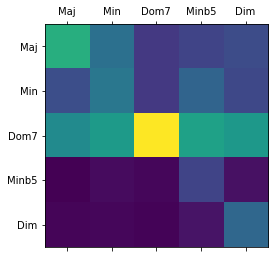

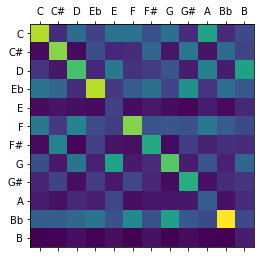

In [ ]:
true_quals = [y//12 for y in y_test]
hmm_quals = [y//12 for y in hmm_labels]

true_keys = [y%12 for y in y_test]
hmm_keys = [y%12 for y in hmm_labels]

plt.matshow(metrics.confusion_matrix(true_quals,hmm_quals, normalize='pred'))
plt.xticks(np.arange(5),["Maj","Min","Dom7","Minb5","Dim"])
plt.yticks(np.arange(5),["Maj","Min","Dom7","Minb5","Dim"])
plt.show()
plt.matshow(metrics.confusion_matrix(true_keys,hmm_keys, normalize='pred'))
plt.xticks(np.arange(12),['C','C#','D','Eb','E','F','F#','G','G#','A','Bb','B'])
plt.yticks(np.arange(12),['C','C#','D','Eb','E','F','F#','G','G#','A','Bb','B'])
plt.show()

## Some last words

The fact that there are so many chroma expressions that go with a certain seventh chord makes it very difficult to build a chord classification algorithm. Especially in the jazz context, the content of the chromas could be notes belonging far outside the prototype of the chord, and even so the author of the annotations could easily classify what chord is played hearing its context, the bass note etc. A lot of training is needed even for a skilled musician, in order to accurately classify chords.

Also chromas are seen as vectors in $\mathbb{R}^{12}$ making it hard to get an intuition for what is the best way of measuring similarity. Here we are using mean vectors and scalar products, but does it acutally reflect the essence of a "prototype chord chroma"? Another interesting approach would be to set a limit for how much the magnitude value can deviate from some standard, and then only consider the elements that are large enough, making a binary vector. (For example only considering C, E, G if those chroma elements are largest). That would lead to us introducing bias on the model, but that would hopefully deal with the fact that there might be some parameters that are unnecessary. 

## References

Eremenko V, Demirel E, Bozkurt B, Serra X. 2018. AUDIO-ALIGNED JAZZ HARMONY DATASET FOR AUTOMATIC
CHORD TRANSCRIPTION AND CORPUS-BASED RESEARCH. Proceedings of the 19th ISMIR Conference, Paris, France. pp 483-490.

